In [1]:
import pandas as pd
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# K>=5 DataSet Loading

In [3]:
from sklearn.model_selection import train_test_split
df_E = pd.read_csv("DataCSV/Elliptical.csv")
df_S = pd.read_csv("DataCSV/Spiral.csv")
df = pd.concat([df_E,df_S],axis=0)
df = df[df['K']>=10]
df = df[['PATH','class']].reset_index()
y = df['class']
x = df.drop('class',axis=1)

In [4]:
img_list = []
size = 64#Image Size
for i in range(len(x)):
    img_data = cv2.imread(x.PATH[i])
    img_data = cv2.resize(img_data,(size,size))
    img_list.append(img_data)

X_train, X_test, y_train, y_test = train_test_split(img_list, y, test_size=0.2,random_state=1)

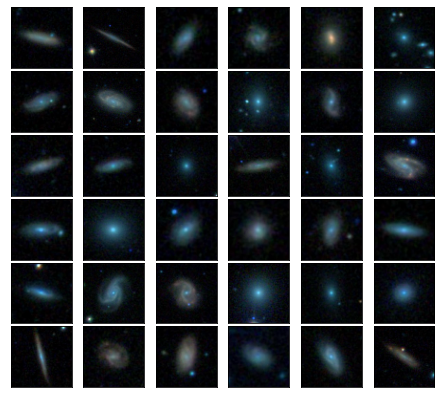

In [5]:
from PIL import Image
W = 6
H = 6

fig = plt.figure(figsize = (H,W))
fig.subplots_adjust(left=0,right=1,bottom=0,hspace=0.05,wspace=0.05)
for i in range(W*H):
    ax = fig.add_subplot(H,W,i+1,xticks=[],yticks=[])
    ax.imshow(X_train[i])
plt.show()

In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = X_train.reshape(X_train.shape[0], size*size*3)
X_test = X_test.reshape(X_test.shape[0], size*size*3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [7]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP,self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.hidden = tf.keras.layers.Dense(256,activation='relu')
        self.outputs = tf.keras.layers.Dense(2, activation='softmax')
        
    def call(self, x):
      # Functional APIのように記述できる
      x = self.flatten(x)
      x = self.hidden(x)
      return self.outputs(x)
model = MLP()

In [8]:
@tf.function
def train_step(images, labels):
    # with内部の勾配を計算
    with tf.GradientTape() as tape: 
        # モデルの前進処理
        logits = model(images) 
        # 損失の計算
        loss_value = loss_object(y_true=labels, y_pred=logits)
    # 損失に対する勾配を求める 
    grads = tape.gradient(loss_value, model.trainable_variables)
    # 指定した最適化関数を用いてモデルの更新
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # 訓練の損失を記録 
    train_loss(loss_value)
    # 訓練の正答率を記録
    train_accuracy(y_true=labels, y_pred=logits)
# tf.functionでグラフへコンパイルする
@tf.function
def test_step(images, labels):
    # モデルの前進処理 
    predictions = model(images)
    # 損失の計算
    t_loss = loss_object(labels, predictions)
    # テストの損失を記録
    test_loss(t_loss)
    # テストの正答率を記録
    test_accuracy(labels, predictions)

In [9]:
# 損失のインスタンスの生成
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
# 最適化関数のインスタンスの生成
optimizer = tf.keras.optimizers.Adam()
# 訓練の損失を記録するインスタンスの生成
train_loss = tf.keras.metrics.Mean(name='train_loss')
# 訓練の正答率を記録するインスタンスの生成
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
# テストの損失を記録するインスタンスの生成
test_loss = tf.keras.metrics.Mean(name='test_loss')
# テストの正答率を記録するインスタンスの生成
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [10]:
loss_history,accuracy_history = [],[]
epoch = 20
#train(model, X_train, y_train, epochs=20, batch_size=128)
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(128)
# Epoch回train_stepで訓練する 
for epoch in range(epoch):
    for ds in ds_train:
        train_step(ds[0], ds[1])
    # 訓練履歴の出力
    template = 'Epoch {}, Loss: {}, Accuracy: {}'
    tf.print(template.format(epoch+1,
                             train_loss.result(),
                             train_accuracy.result()*100))
# 訓練履歴のリセット
    loss_history.append(train_loss.result())
    accuracy_history.append(train_accuracy.result())
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch 1, Loss: 0.1698412001132965, Accuracy: 93.68197631835938
Epoch 2, Loss: 0.1059645414352417, Accuracy: 96.11095428466797
Epoch 3, Loss: 0.08559831976890564, Accuracy: 97.00202178955078
Epoch 4, Loss: 0.07747086137533188, Accuracy: 97.20332336425781
Epoch 5, Loss: 0.07094257324934006, Accuracy: 97.47306060791016
Epoch 6, Loss: 0.06474131345748901, Accuracy: 97.7038803100586
Epoch 7, Loss: 0.06111830100417137, Accuracy: 97.87296295166016
Epoch 8, Loss: 0.060606032609939575, Accuracy: 97.82733917236328
Epoch 9, Loss: 0.05680203437805176, Accuracy: 98.03534698486328
Epoch 10, Loss: 0.05378442630171776, Accuracy: 98.1480712890625
Epoch 11, Loss: 0.04848366230726242, Accuracy: 98.3117904663086
Epoch 12, Loss: 0.044786207377910614, Accuracy: 98.44062042236328
Epoch 13, Loss: 0.04412706941366196, Accuracy: 98.46209716796875
Epoch 14, Loss: 0.04169289395213127, Accuracy: 98.54530334472656
Epoch 15, Loss: 0.03704233467578888, Accuracy: 98.68888854980469
Epoch 16, Loss: 0.035976018756628036,

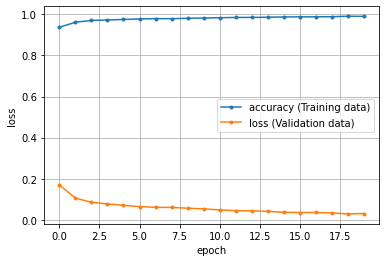

In [11]:
epochs = len(loss_history)
plt.plot(accuracy_history, marker='.', label='accuracy (Training data)')
plt.plot(range(epochs), loss_history, marker='.', label='loss (Validation data)')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix
y_true = np.asarray(y_test)
y_pred = model(np.asarray(X_test))
y_pred = np.argmax(y_pred, axis=1) #reshape(-1,1)
confusion_matrix(y_true, y_pred)

array([[ 4856,   153],
       [  275, 13346]])

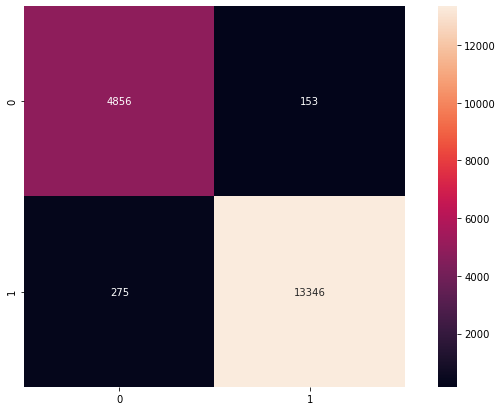

In [13]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    plt.figure(figsize = (12,7))
    sn.heatmap(df_cmx, annot=True, fmt='g' ,square = True)
    plt.show()

print_cmx(y_true , y_pred)

In [14]:
from sklearn.metrics import accuracy_score
print('正解率（accuracy）:', accuracy_score(y_true, y_pred))

from sklearn.metrics import precision_score
print('適合率(precision) : ', precision_score(y_true, y_pred))

from sklearn.metrics import recall_score
print('再現率（recall）:',recall_score(y_true, y_pred, average='macro'))

from sklearn.metrics import f1_score
print('F1値（F1-measure）:',f1_score(y_true, y_pred, average='macro'))

正解率（accuracy）: 0.9770263016639829
適合率(precision) :  0.9886658270983035
再現率（recall）: 0.974632783814184
F1値（F1-measure）: 0.9710046080536209
